In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 1. 시계열 데이터 생성
np.random.seed(42)
n_samples = 1000
timestamps = pd.date_range("2025-01-01", periods=n_samples, freq="H")

X_full = pd.DataFrame({
    "temperature": np.random.uniform(20, 100, n_samples),
    "pressure": np.random.uniform(1, 10, n_samples),
    "humidity": np.random.uniform(10, 90, n_samples)
}, index=timestamps)

In [3]:
# 비선형 수율 함수 정의
y_full = (
    80 * np.exp(-(X_full["temperature"] - 60) ** 2 / 200) +
    10 * np.log(X_full["pressure"]) +
    5 * np.cos(X_full["humidity"] / 15) +
    np.random.normal(0, 2, n_samples)
)
y_full = np.clip(y_full, 0, 100)

# threshold = 50  # 기준값은 원하는 대로 조정 가능
# y_binary = (y_full >= threshold).astype(int)

In [4]:
# 2. 무빙 윈도우 설정
window_size = 100
n_windows = n_samples // window_size

In [5]:
# 결과 저장
all_optimal_ys = []
all_optimal_xs = []
all_actual_ys = []
all_timestamps = []

# 3. 각 윈도우별로 반복
for w in range(n_windows):
    start = w * window_size
    end = start + window_size

    X_window = X_full.iloc[start:end]
    y_window = y_full[start:end]
    time_window = timestamps[start:end]

    # 모델 학습
    model = LinearRegression()
    model.fit(X_window, y_window)

    optimal_ys = []
    optimal_xs = []

    for i in range(window_size):
        def negative_yield(x):
            input_df = pd.DataFrame([{
                "temperature": x[0],
                "pressure": x[1],
                "humidity": x[2]
            }])
            return -model.predict(input_df)[0]

        result = minimize(negative_yield, x0=[60, 5, 50], bounds=[(40, 80), (5, 10), (30, 80)])
        optimal_ys.append(-result.fun)
        optimal_xs.append(result.x)

    # 결과 누적 저장
    all_optimal_ys.extend(optimal_ys)
    all_optimal_xs.extend(optimal_xs)
    all_actual_ys.extend(y_window)
    all_timestamps.extend(time_window)

# 배열로 변환
all_optimal_ys = np.array(all_optimal_ys)
all_optimal_xs = np.array(all_optimal_xs)


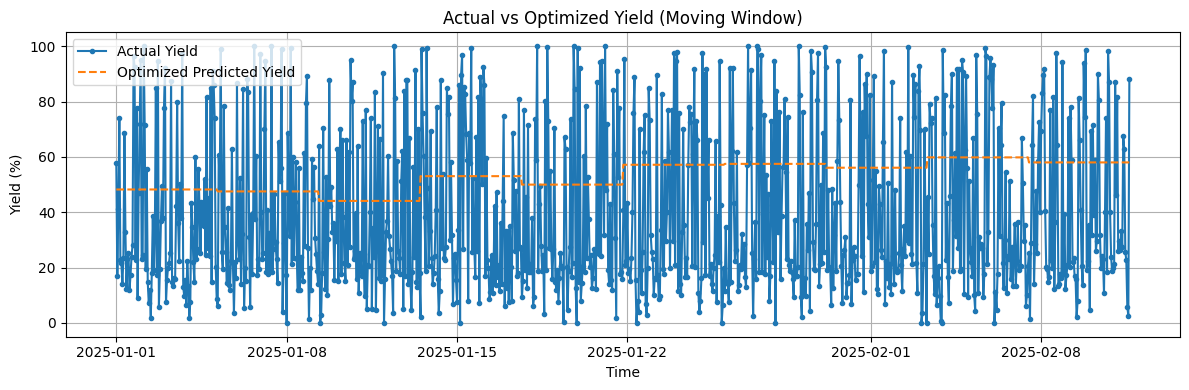

In [6]:
# 4. 수율 시각화
plt.figure(figsize=(12, 4))
plt.plot(all_timestamps, all_actual_ys, label="Actual Yield", marker='.')
plt.plot(all_timestamps, all_optimal_ys, label="Optimized Predicted Yield", linestyle='--')
plt.title("Actual vs Optimized Yield (Moving Window)")
plt.ylabel("Yield (%)")
plt.xlabel("Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

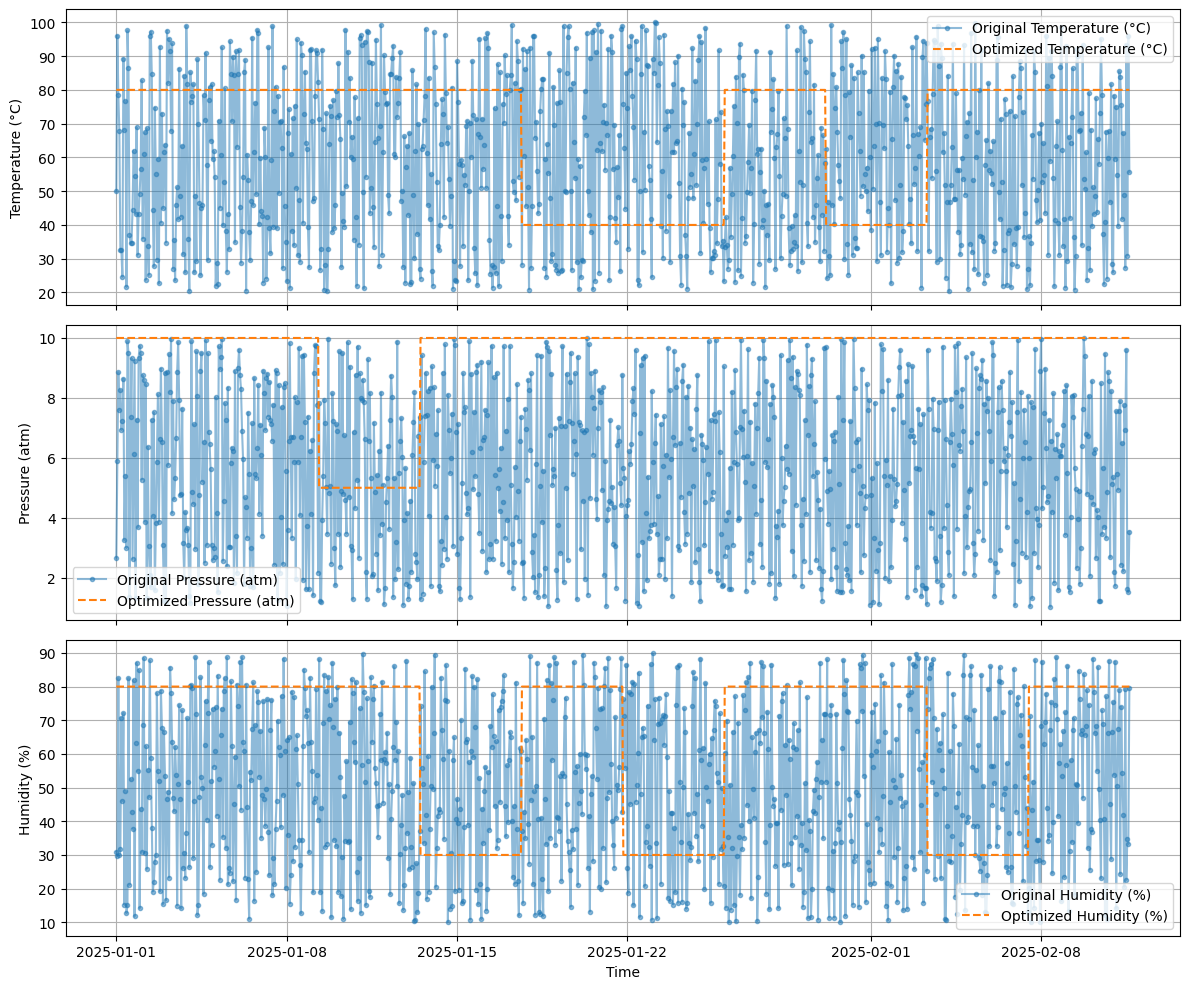

In [7]:
# 5. 공정 조건 시각화
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
labels = ["Temperature (°C)", "Pressure (atm)", "Humidity (%)"]
for i in range(3):
    ax[i].plot(all_timestamps, X_full.iloc[:, i], label=f"Original {labels[i]}", marker='.', alpha=0.5)
    ax[i].plot(all_timestamps, all_optimal_xs[:, i], label=f"Optimized {labels[i]}", linestyle='--')
    ax[i].set_ylabel(labels[i])
    ax[i].legend()
    ax[i].grid(True)
ax[-1].set_xlabel("Time")
plt.tight_layout()
plt.show()

In [8]:
# 6. 최종 결과 저장
result_df = X_full.copy()
result_df["actual_yield"] = all_actual_ys
result_df["optimized_yield"] = all_optimal_ys
result_df["opt_temperature"] = all_optimal_xs[:, 0]
result_df["opt_pressure"] = all_optimal_xs[:, 1]
result_df["opt_humidity"] = all_optimal_xs[:, 2]

In [9]:
result_df

,temperature,pressure,humidity,actual_yield,optimized_yield,opt_temperature,opt_pressure,opt_humidity
2025-01-01 00:00:00,49.963210,2.666196,30.936455,57.910004,48.211490,80.0,10.0,80.0
2025-01-01 01:00:00,96.057145,5.877109,29.758304,17.057656,48.211490,80.0,10.0,80.0
2025-01-01 02:00:00,78.559515,8.856513,82.500366,41.014800,48.211490,80.0,10.0,80.0
2025-01-01 03:00:00,67.892679,7.590024,29.963696,74.056168,48.211490,80.0,10.0,80.0
2025-01-01 04:00:00,32.481491,8.259050,31.755978,22.753744,48.211490,80.0,10.0,80.0
...,...,...,...,...,...,...,...,...
2025-02-11 11:00:00,27.326566,6.912596,79.223661,25.669661,57.991911,80.0,10.0,80.0
2025-02-11 12:00:00,93.385086,9.609532,22.581857,22.689229,57.991911,80.0,10.0,80.0
2025-02-11 13:00:00,30.945490,1.620622,34.783029,5.783055,57.991911,80.0,10.0,80.0
2025-02-11 14:00:00,96.018988,1.513492,33.203643,2.626816,57.991911,80.0,10.0,80.0
